# Wine Quality Prediction Proposal

### Introduction

For thousands of years, high quality wine-making was an art that demanded recipes and techniques passed down from generations to generations through trial and error. In the past century, rapid scientific advancement has changed the wine-making process through its discovery on how certain ingredients contribute to important chemical reactions in steps like fermentation. Due in part to these advancements, the wine industry has become more complex and competitive and efficiency is more important than ever.

The dataset used is the Red Wine Quality Dataset found on the UCI Machine Learning Repository, containing the quality and physicochemical properties of 1599 red wine samples from the northwest region of Portugal, called *vinho verde* wine. This data was collected from May 2004 to February 2007

Portugal is the 11th largest producer of wine in the world and its wine industry makes up 10% of its manufacturing companies and 25% of turnover. [1] In the increasingly global market, wine quality evaluation has become a necessary certification process that stratifies premium and table wines, to name a few. This process provides key insights for manafacturers and economists alike and can measure efficiency for the best production output. A higher quality wine can generate a significantly higher revenue in the increasingly competitive world industry. 

Wine certification characterizes wine based on physiochemical properties (ie. density, pH, and alcohol) and human expert taste testers. The relationship between theses two assessments is complex and not well established, since taste is subjective.  

In this project, we are aiming to create a classification model that predicts the quality of wine from a scale of 1-8 using ??? physiochemical factors: volatile acidity (level of wine's gaseous acid), alcohol, total sulfur dioxide, and sulphates. 

In [1]:
install.packages("GGally")
install.packages("corrplot")  
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)
library(GGally)       
library(corrplot)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
winequalityRed <- read_csv2("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")|> 
                    mutate(quality = as.factor(quality))
head(winequalityRed)



ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 1599 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): volatile acidity, citric acid, chlorides, density, sulphates
dbl (2): total sulfur dioxide, quality

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<fct>
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.997,326,0.65,98,5
112,0.28,0.56,19,0.075,17,60,0.998,316,0.58,98,6
74,0.7,0,19,0.076,11,34,0.9978,351,0.56,94,5
74,0.66,0,18,0.075,13,40,0.9978,351,0.56,94,5


In [4]:
completedt <- winequalityRed |>
              setNames(c("fixed_acidity",
                         "volatile_acidity",
                         "citric_acid",
                         "residual_sugar",
                         "chlorides",
                         "free_SO2",
                         "total_SO2",
                         "density",
                         "pH",
                         "sulphates",
                         "alcohol",
                         "quality",
                         "type"))
completedt$volatile_acidity <- as.numeric(completedt$volatile_acidity)
completedt$citric_acid <- as.numeric(completedt$citric_acid)
completedt$residual_sugar <- as.numeric(completedt$residual_sugar)
completedt$chlorides <- as.numeric(completedt$chlorides)
completedt$density <- as.numeric(completedt$density)
completedt$sulphates <- as.numeric(completedt$sulphates)
head(completedt)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.70,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.88,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
78,0.76,0.04,23,0.092,15,54,0.9970,326,0.65,98,5
112,0.28,0.56,19,0.075,17,60,0.9980,316,0.58,98,6
74,0.70,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
74,0.66,0.00,18,0.075,13,40,0.9978,351,0.56,94,5


In [5]:
set.seed(100)
wine_split <- initial_split(completedt, prop = 0.75, strata = quality)
wine_training <- training(wine_split)
wine_testing <- testing(wine_split)
head(wine_training)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
74,0.700,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
78,0.880,0.00,26,0.098,25,67,0.9968,32,0.68,98,5
74,0.700,0.00,19,0.076,11,34,0.9978,351,0.56,94,5
79,0.600,0.06,16,0.069,15,59,0.9964,33,0.46,94,5
75,0.500,0.36,61,0.071,17,102,0.9978,335,0.80,105,5
56,0.615,0.00,16,0.089,16,59,0.9943,358,0.52,99,5


In [6]:
wine_training |> group_by(quality) |> summarize(n=n())

quality,n
<fct>,<int>
3,10
4,40
5,509
6,479
7,147
8,13


In [7]:
library(themis)

In [8]:
set.seed(100)
ups_recipe <- recipe(quality ~ ., data = wine_training) |>
  step_upsample(quality, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

wine_training <- bake(ups_recipe, wine_training)

upsampled_wine <- wine_training |> group_by(quality) |> summarize(n=n())
upsampled_wine

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         11

Training data contained 1198 data points and 1 incomplete row. 

Operations:

Up-sampling based on quality [trained]

quality,n
<fct>,<int>
3,509
4,509
5,509
6,509
7,509
8,509


In [9]:
#generating a correlation matrix between all numeric variables 
wine_training_corr <- wine_training|>
                     mutate_at(c('quality'), as.numeric)|>
                     filter(!is.na(total_SO2))
                    
winequalitycorr <-cor(wine_training_corr)

head(round(winequalitycorr,2))

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
fixed_acidity,1.00,-0.14,0.43,0.06,0.07,-0.11,-0.14,0.43,-0.01,0.18,0.00,0.07
volatile_acidity,-0.14,1.00,-0.63,0.25,0.12,-0.14,-0.13,0.03,-0.13,-0.42,0.01,-0.64
citric_acid,0.43,-0.63,1.00,-0.06,0.19,0.07,0.11,0.35,-0.01,0.50,-0.01,0.46
residual_sugar,0.06,0.25,-0.06,1.00,0.01,-0.02,-0.06,0.09,0.07,-0.04,0.00,-0.12
chlorides,0.07,0.12,0.19,0.01,1.00,0.05,0.05,0.18,-0.06,0.45,0.00,-0.25
free_SO2,-0.11,-0.14,0.07,-0.02,0.05,1.00,0.65,-0.07,0.04,0.09,0.01,0.01


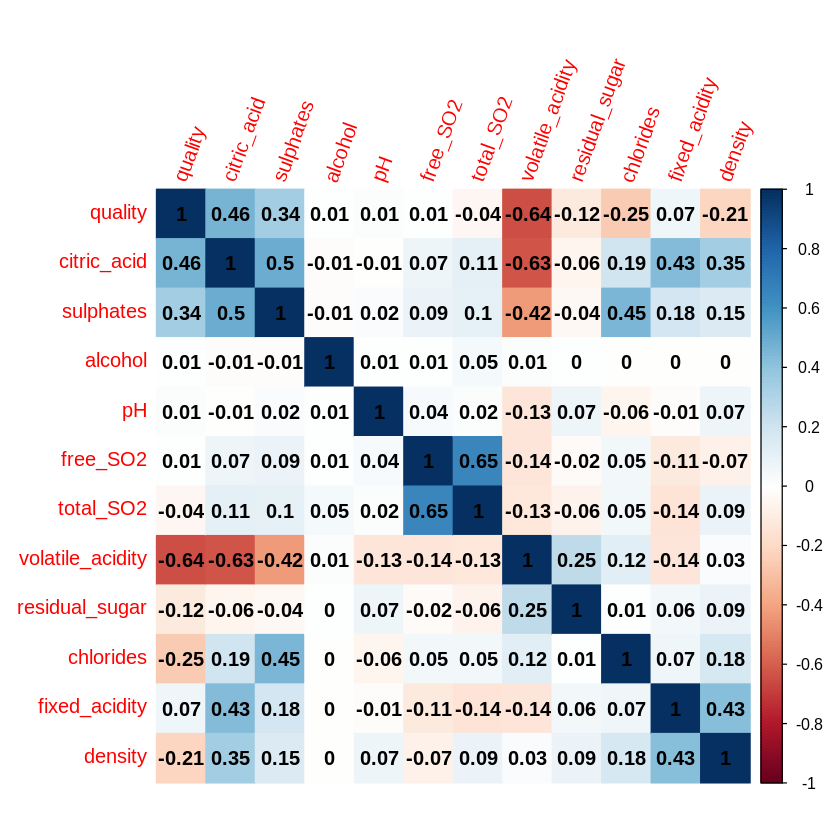

In [10]:
set.seed(100)
corrplot(winequalitycorr, method = 'color', order = 'hclust', addCoef.col = 1,  
       tl.cex = 1, number.cex = 1, tl.srt= 70)

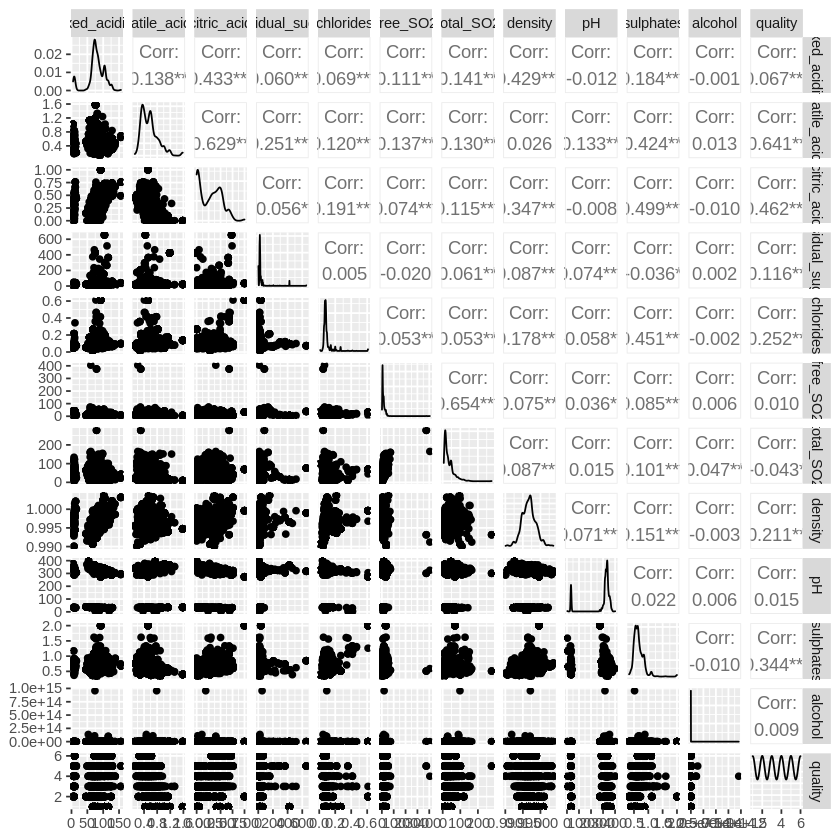

In [11]:
ggpairs(wine_training_corr) 

In [12]:
wine_training <- wine_training |>
                mutate(across(is.numeric, ~ as.numeric(scale(sulphates)))) 
           
                      
quality_sulphates <- ggplot(wine_training, aes(quality,sulphates)) +
                    geom_boxplot()+
                    ggtitle("Quality vs. Sulphates")+
                    theme(text=element_text(size=20))
                    


Warning message:
“Predicate functions must be wrapped in `where()`.

  # Bad
  data %>% select(is.numeric)

  # Good
  data %>% select(where(is.numeric))

ℹ Please update your code.
This message is displayed once per session.”


In [13]:
wine_training <- wine_training |>
                mutate(across(is.numeric, ~ as.numeric(scale(citric_acid)))) 
           
quality_citric_acid <- ggplot(wine_training, aes(quality, citric_acid))+
                       geom_boxplot()+
                    ggtitle("Quality vs. Citric Acid")+
                    theme(text=element_text(size=20))



In [14]:
wine_training <- wine_training |>
                mutate(across(is.numeric, ~ as.numeric(scale(volatile_acidity))))

quality_volatile_acidity <- ggplot(wine_training, aes(quality, volatile_acidity))+ 
                    geom_boxplot()+
                    ggtitle("Quality vs. Volatile Acidity")+
                    theme(text=element_text(size=20))





In [15]:
wine_training <- wine_training |>
                mutate(across(is.numeric, ~ as.numeric(scale(chlorides))))

quality_chlorides <- ggplot(wine_training, aes(quality, chlorides))+ 
                    geom_boxplot()+
                    ggtitle("Quality vs. Chlorides")+
                    theme(text=element_text(size=20))

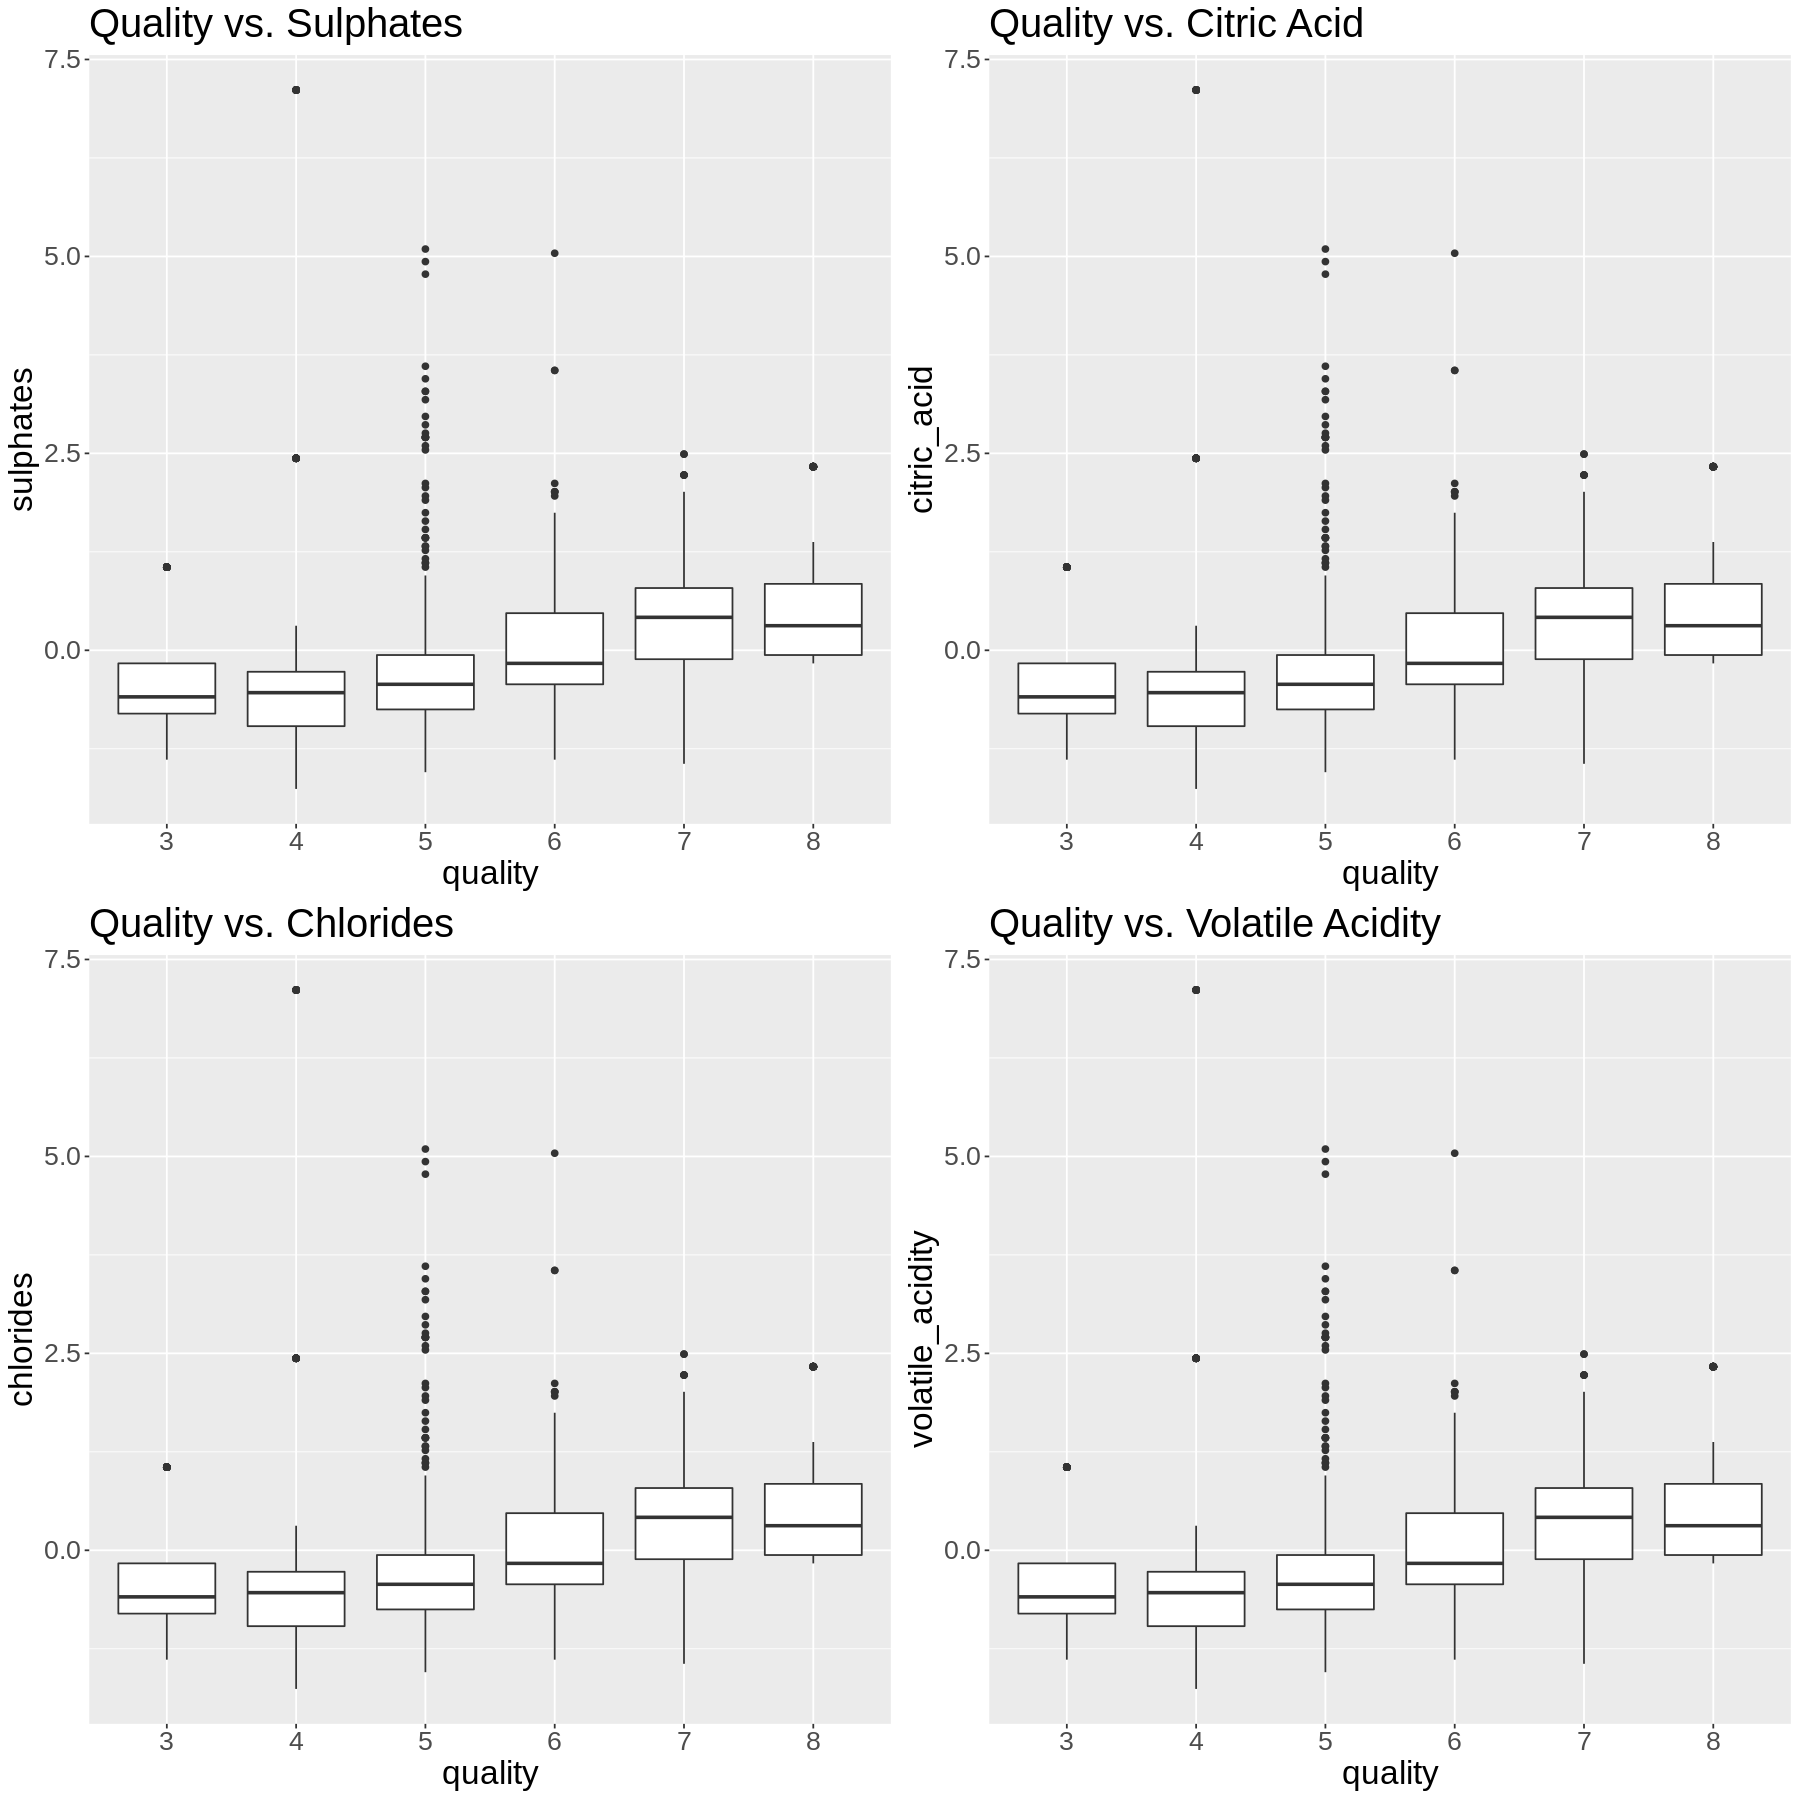

In [16]:
options(repr.plot.width = 15, repr.plot.height = 15)
quality_panel<- plot_grid(quality_sulphates, quality_citric_acid,
                                        quality_chlorides, quality_volatile_acidity, 
                                        ncol = 2)

quality_panel

In [17]:
set.seed(100)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn")|>
            set_mode("classification")

k_vals <- tibble(neighbors = seq(from= 1, to = 100, by = 5))

knn_recipe <- recipe(quality~sulphates + citric_acid + chlorides + volatile_acidity, data = wine_training) |>
                 step_scale(all_predictors()) |>
                 step_center(all_predictors())

wine_vfold <- vfold_cv(wine_training, v = 5, strata = quality)

# wine_vfold

In [ ]:
set.seed(100)
knn_results <- workflow() |>
                add_recipe(knn_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = wine_vfold, grid = k_vals) |>
                collect_metrics()

accuracies <- knn_results |> filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                 geom_point() +
                 geom_line()+
                 labs(x="Neighbors", y="Accuracy Estimate") + 
                 scale_x_continuous(breaks = seq(1, 100, by = 5))
accuracy_vs_k

From the graph, we will choose k = 46 to be our neighbour value since it is the highest accuracy point

In [ ]:
seet.seed(100)
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 46) |>
                  set_engine("kknn")|>
                  set_mode("classification")

# Using the same recipe as above, we build our classification model

wine_fit <- workflow() |>
            add_recipe(knn_recipe) |>
            add_model(knn_spec_final) |>
            fit(data = wine_training)

wine_fit

In [ ]:
set.seed(100)
# Prediction
wine_predictions <- predict(wine_fit, wine_testing) |>
                    bind_cols(wine_testing)
head(wine_predictions)

# Confusion Matrix
wine_metrics <- wine_predictions |>
                metrics(truth = quality, estimate = .pred_class)

wine_conf_mat <- wine_predictions |> 
                 conf_mat(truth = quality, estimate = .pred_class)
wine_conf_mat

## Methods & Results

### Exploratory Data Analysis

To find the best predictors for our model, we began by calculating the correlation coefficients between all variables. The correlation coefficent measures the strength of a linear relationship between 2 variables. 